Generating synthetic quantum data...
Training SVMs...
  Linear: MSE=0.1019, R2=0.9784
  RBF: MSE=0.0068, R2=0.9986
  Poly (Deg 3): MSE=0.0048, R2=0.9990
  Sigmoid: MSE=2595834.0667, R2=-549427.3282


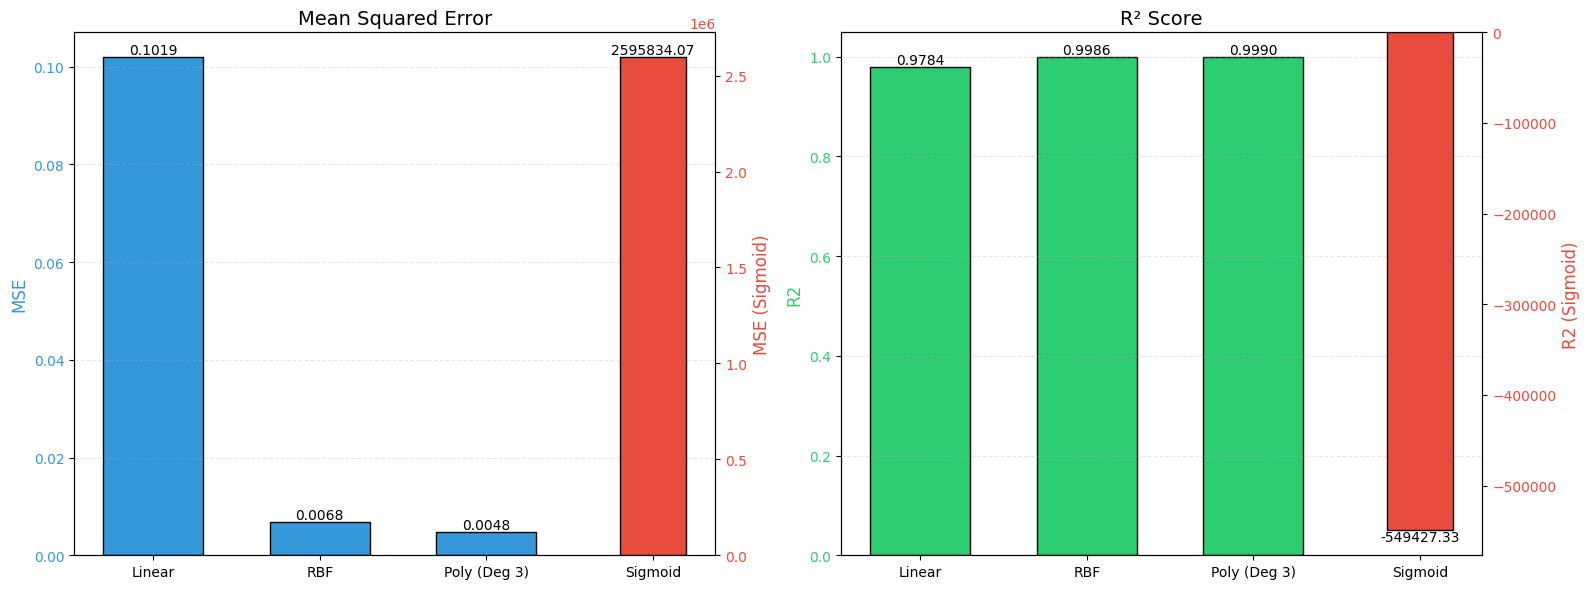

In [9]:
# -----------------------------------------------------------------------------
# Copyright (c) 2025 Renata Wong
#
# This code is supplementary material for the research paper:
# "Support Vector Machine Kernels as Quantum Propagators"
#
# Licensed under the MIT License.
# You may obtain a copy of the License at: https://opensource.org/licenses/MIT
# -----------------------------------------------------------------------------


import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# ==========================================
# 1. PHYSICS SIMULATION (Dataset Generation)
# ==========================================
def solve_anharmonic_oscillator(n_levels, k, alpha, grid_size=1000, x_max=10):
    """
    Numerically solves the Schrodinger equation for an anharmonic oscillator
    H = -0.5 * d^2/dx^2 + 0.5 * k * x^2 + alpha * x^4
    Returns the n-th energy eigenvalue.
    """
    # Discretize space
    x = np.linspace(-x_max, x_max, grid_size)
    dx = x[1] - x[0]
    
    # Potential Energy V(x)
    V = 0.5 * k * x**2 + alpha * x**4
    
    # Kinetic Energy T (Finite Difference Method for 2nd derivative)
    # Diagonal: 2/dx^2, Off-diagonal: -1/dx^2
    diag_main = 1.0 / (dx**2) * np.ones(grid_size)
    diag_off = -0.5 / (dx**2) * np.ones(grid_size - 1)
    
    # Hamiltonian H = T + V
    # We construct H as a sparse matrix
    H_diag = diag_main + V
    H = diags([diag_off, H_diag, diag_off], [-1, 0, 1])
    
    # Solve eigenvalue problem (find lowest n_levels energies)
    # We request n_levels + 1 to ensure we get the specific state needed
    # (Though typically we solve for all low lying states at once)
    eigenvalues, _ = eigsh(H, k=n_levels+5, which='SA') # 'SA' = Smallest Algebraic
    
    return eigenvalues


print("Generating synthetic quantum data...")
N_SAMPLES = 500
X_data = []
y_data = []
np.random.seed(42)
ns = np.random.randint(0, 5, N_SAMPLES)
ks = np.random.uniform(0.5, 2.0, N_SAMPLES)
alphas = np.random.uniform(0.01, 0.2, N_SAMPLES)

for i in range(N_SAMPLES):
    n = ns[i]
    k = ks[i]
    alpha = alphas[i]
    energies = solve_anharmonic_oscillator(n_levels=n+1, k=k, alpha=alpha)
    X_data.append([n, k, alpha])
    y_data.append(energies[n])

X = np.array(X_data)
y = np.array(y_data)

# ==========================================
# 2. PREPROCESSING & SVM TRAINING
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

kernels = {
    'Linear': SVR(kernel='linear', C=100),
    'RBF': SVR(kernel='rbf', C=100, gamma='scale'),
    'Poly (Deg 3)': SVR(kernel='poly', degree=3, C=100, coef0=1),
    'Sigmoid': SVR(kernel='sigmoid', C=100, coef0=1)
}

results = {'MSE': [], 'R2': [], 'Names': []}

print("Training SVMs...")
for name, model in kernels.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results['MSE'].append(mse)
    results['R2'].append(r2)
    results['Names'].append(name)
    print(f"  {name}: MSE={mse:.4f}, R2={r2:.4f}")

# ==========================================
# 3. PLOTTING WITH DUAL Y-AXES
# ==========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Helper function for dual-axis bar plot
def plot_dual_axis(ax_left, metric_key, title, left_color, right_color):
    names = results['Names']
    values = results[metric_key]
    
    # Separate data indices
    sigmoid_idx = [i for i, n in enumerate(names) if 'Sigmoid' in n]
    others_idx = [i for i, n in enumerate(names) if 'Sigmoid' not in n]
    
    # Left Axis (Standard Kernels)
    bars1 = ax_left.bar([names[i] for i in others_idx], 
                        [values[i] for i in others_idx], 
                        color=left_color, edgecolor='black', label='Standard Kernels', width=0.6)
    ax_left.set_ylabel(f'{metric_key}', color=left_color, fontsize=12)
    ax_left.tick_params(axis='y', labelcolor=left_color)
    ax_left.set_title(title, fontsize=14)
    ax_left.grid(axis='y', linestyle='--', alpha=0.3)

    # Right Axis (Sigmoid)
    ax_right = ax_left.twinx()
    bars2 = ax_right.bar([names[i] for i in sigmoid_idx], 
                         [values[i] for i in sigmoid_idx], 
                         color=right_color, edgecolor='black', label='Sigmoid Kernel', width=0.4)
    ax_right.set_ylabel(f'{metric_key} (Sigmoid)', color=right_color, fontsize=12)
    ax_right.tick_params(axis='y', labelcolor=right_color)
    
    # Add value labels
    for bar in bars1:
        h = bar.get_height()
        ax_left.text(bar.get_x() + bar.get_width()/2, h, f'{h:.4f}', 
                     ha='center', va='bottom', color='black')
    for bar in bars2:
        h = bar.get_height()
        # For R2, sigmoid is usually negative, put label above or below accordingly
        va = 'bottom' if h > 0 else 'top'
        y_pos = 0 if h < 0 else h # Adjust if needed for visibility
        ax_right.text(bar.get_x() + bar.get_width()/2, h, f'{h:.2f}', 
                      ha='center', va=va, color='black')

# Plot 1: MSE
plot_dual_axis(ax1, 'MSE', 'Mean Squared Error', '#3498db', '#e74c3c')

# Plot 2: R2
plot_dual_axis(ax2, 'R2', 'R² Score', '#2ecc71', '#e74c3c')

plt.tight_layout()
plt.show()

Generating synthetic quantum data...
Training Polynomial SVMs...
  Poly (Deg 2): MSE=0.0045, R2=0.9990
  Poly (Deg 3): MSE=0.0048, R2=0.9990
  Poly (Deg 4): MSE=0.0067, R2=0.9986
  Poly (Deg 5): MSE=0.0062, R2=0.9987
  Poly (Deg 6): MSE=0.0059, R2=0.9988
  Poly (Deg 7): MSE=0.0073, R2=0.9985


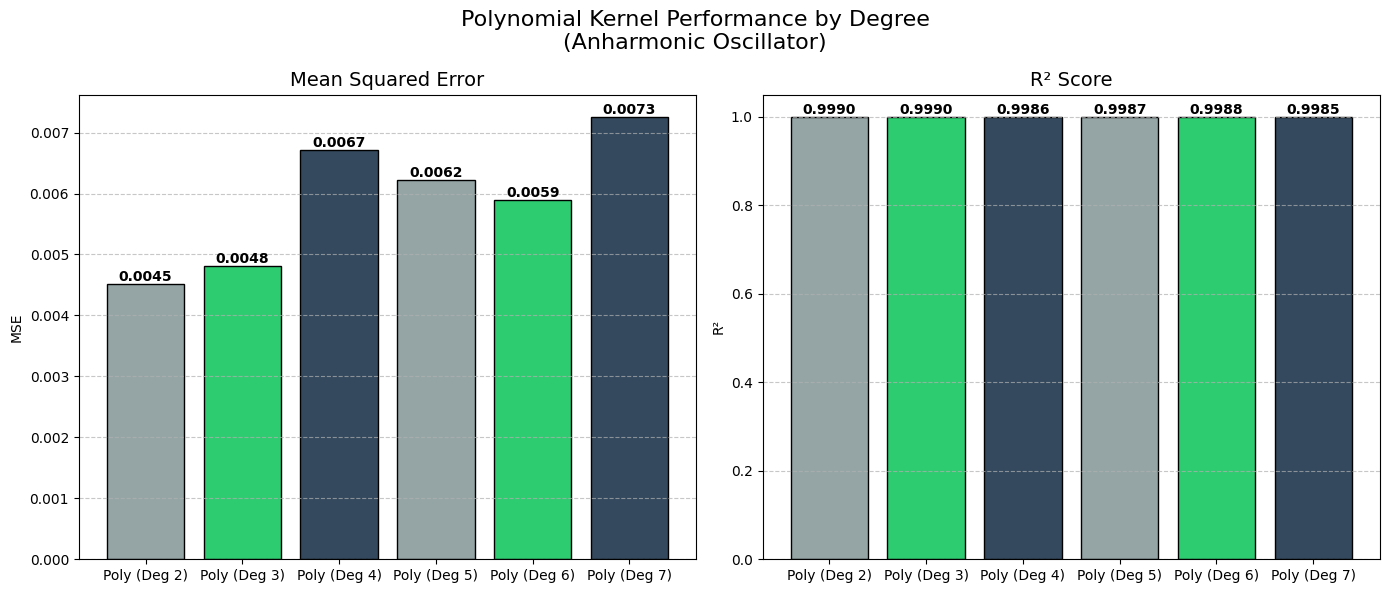

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# ==========================================
# 1. PHYSICS SIMULATION (Dataset Generation)
# ==========================================
def solve_anharmonic_oscillator(n_levels, k, alpha, grid_size=1000, x_max=10):
    x = np.linspace(-x_max, x_max, grid_size)
    dx = x[1] - x[0]
    V = 0.5 * k * x**2 + alpha * x**4
    diag_main = 1.0 / (dx**2) * np.ones(grid_size)
    diag_off = -0.5 / (dx**2) * np.ones(grid_size - 1)
    H_diag = diag_main + V
    H = diags([diag_off, H_diag, diag_off], [-1, 0, 1])
    eigenvalues, _ = eigsh(H, k=n_levels+5, which='SA')
    return eigenvalues

print("Generating synthetic quantum data...")
N_SAMPLES = 500
X_data = []
y_data = []
np.random.seed(42)
ns = np.random.randint(0, 5, N_SAMPLES)
ks = np.random.uniform(0.5, 2.0, N_SAMPLES)
alphas = np.random.uniform(0.01, 0.2, N_SAMPLES)

for i in range(N_SAMPLES):
    n = ns[i]
    k = ks[i]
    alpha = alphas[i]
    energies = solve_anharmonic_oscillator(n_levels=n+1, k=k, alpha=alpha)
    X_data.append([n, k, alpha])
    y_data.append(energies[n])

X = np.array(X_data)
y = np.array(y_data)

# ==========================================
# 2. PREPROCESSING & SVM TRAINING
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

kernels = {
    'Poly (Deg 2)': SVR(kernel='poly', degree=2, C=100, coef0=1),
    'Poly (Deg 3)': SVR(kernel='poly', degree=3, C=100, coef0=1),
    'Poly (Deg 4)': SVR(kernel='poly', degree=4, C=100, coef0=1),
    'Poly (Deg 5)': SVR(kernel='poly', degree=5, C=100, coef0=1),
    'Poly (Deg 6)': SVR(kernel='poly', degree=6, C=100, coef0=1),
    'Poly (Deg 7)': SVR(kernel='poly', degree=7, C=100, coef0=1)
}

results_mse = []
results_r2 = []
kernel_names = []

print("Training Polynomial SVMs...")
for name, model in kernels.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results_mse.append(mse)
    results_r2.append(r2)
    kernel_names.append(name)
    print(f"  {name}: MSE={mse:.4f}, R2={r2:.4f}")

# ==========================================
# 3. PLOTTING RESULTS
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Define colors for degrees
colors = ['#95a5a6', '#2ecc71', '#34495e'] # Grey, Green (Best), Dark Blue

# Plot 1: MSE
bars1 = axes[0].bar(kernel_names, results_mse, color=colors, edgecolor='black')
axes[0].set_title('Mean Squared Error', fontsize=14)
axes[0].set_ylabel('MSE')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: R2 Score
bars2 = axes[1].bar(kernel_names, results_r2, color=colors, edgecolor='black')
axes[1].set_title('R² Score', fontsize=14)
axes[1].set_ylabel('R²')
axes[1].set_ylim(0, 1.05) # Poly kernels are generally stable, no need for dual axis
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add labels
for ax, bars in zip(axes, [bars1, bars2]):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Polynomial Kernel Performance by Degree\n(Anharmonic Oscillator)', fontsize=16)
plt.tight_layout()
plt.show()